# Main Visualization Notebook

This notebook generates the key figures used in the results section. Data is created in the `Main_data_generation_document` and required here for plotting. All figures are saved to the `plots` folder. Parts of the code and comments were generated with help from large language models like ChatGPT.

We begin by importing the necessary libraries.


In [1]:

import os
import warnings
import re
from datetime import datetime

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
from SALib.analyze import sobol


from ema_workbench import MultiprocessingEvaluator, Policy, Scenario
from ema_workbench.analysis import dimensional_stacking, parcoords, prim
from ema_workbench.em_framework.optimization import EpsilonProgress, EpsNSGAII
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.util import ema_logging


from problem_formulation import get_model_for_problem_formulation

# Suppress warnings
warnings.filterwarnings("ignore")

# Display all columns in pandas DataFrames
pd.set_option('display.max_columns', None)

# Initialize model
dike_model, planning_steps = get_model_for_problem_formulation(2)


# Open Exploration

## 'do-nothing' policy
In this section of the notebook, the various plots for the open exploration are created. The open exploration starts with looking at the results of a 'do nothing' policy run, this run will be used to generate scenarios which are used during the directed search. Next, subspace partitioning (PRIM, DS) is applied. Finally, a (global) sensitivity analysis (GSA) is performed using sobol indices. 

## Exploration using the zero-policy run
Firstly, the model has been run using 100 000 scenarios (using LHS) and a 'do nothing' policy. A 'do nothing' policy means that no actions are taken, all model levers have value 0. This answers the question: 'what are the consequences of not taking actions?'

In [3]:
# Load 'do nothing' policy data from the results folder
zero_policy_experiments = pd.read_csv("zero_policy_results/scenario_space_100000_experiments.csv")
zero_policy_outcomes = pd.read_csv("zero_policy_results/scenario_space_100000_outcomes.csv")

In [ ]:
zero_policy_outcomes.head()

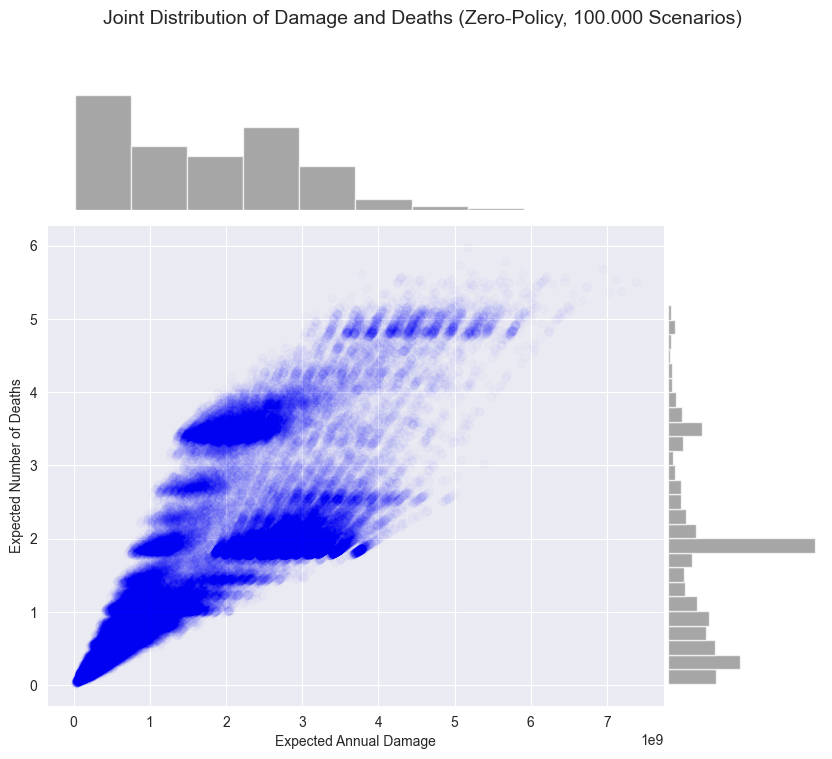

In [4]:
zero_policy_combined_df = pd.concat([zero_policy_experiments, zero_policy_outcomes], axis=1)

# Create a figure with a custom layout
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.01)

# Scatter plot
ax_scatter = fig.add_subplot(gs[1, 0])
ax_scatter.scatter(zero_policy_combined_df['Expected Annual Damage'], zero_policy_combined_df['Expected Number of Deaths'], c='blue', alpha=0.01)
ax_scatter.set_xlabel('Expected Annual Damage')
ax_scatter.set_ylabel('Expected Number of Deaths')
ax_scatter.grid(True)

# Histogram for RfR Total Costs
ax_hist_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_hist_x.hist(zero_policy_combined_df['Expected Annual Damage'], bins=10, color='gray', alpha=0.7)
ax_hist_x.axis('off')

# Histogram for Total Deaths
ax_hist_y = fig.add_subplot(gs[1, 1], sharey=ax_scatter)
ax_hist_y.hist(zero_policy_combined_df['Expected Number of Deaths'], bins=30, orientation='horizontal', color='gray', alpha=0.7)
ax_hist_y.axis('off')
plt.suptitle('Joint Distribution of Damage and Deaths (Zero-Policy, 100.000 Scenarios)', fontsize=14)

output_folder = 'plots'
os.makedirs(output_folder, exist_ok=True)

# Save the figure to the plots folder
save_path = os.path.join(output_folder, 'damage_vs_deaths_exploration_plot.png')

plt.savefig(save_path, facecolor='white', edgecolor='white', bbox_inches='tight', dpi=300)

plt.show()

This plot shows what can be expected when no measures are taken. Some scenarios lead to low damage and few casualties, even without any measures. These are considered favourable and are found in the range $([0,1],\ [0,1])$ for both damage and deaths.

On the other side, there are scenarios with very high damages and loss of life. These are the most unfavourable cases and fall within $([6,\ \infty],\ [5,\ \infty])$. Two other areas stand out in the middle range. One has relatively high deaths and moderate damage, at roughly $([1.5,\ 2.5],\ [3,\ 4])$, while the other has higher damage but fewer deaths, around $([2.5,\ 3.5],\ [1.8,\ 2.8])$.

Based on these areas, a scenario space made by randomly selecting scenarios for further optimization. This is described in the main generation code.

### PRIM
In this section, the Patient Rule Induction Method (PRIM) is applied to analyze the results of a run with 600 scenarios and 400 policies. This data has been produced using latin hypercube sampling (LHS) in both the uncertainty and lever space. The goal is to identify the key uncertainties and policy levers that influence the outcomes of interest.

The analysis focuses on two key questions:
1) Unfavorable outcomes: What values of which uncertainties lead to outcomes with a high number of deaths and damages?
    
    - The threshold for unfavourable outcomes is set at the 40th percentile (0.4 quantile) for both the number of deaths and annual damages. Ideally a higher threshold would have been chosen, but the PRIM algorithm did not work for higher thresholds. 
2) Favorable outcomes: What values of which policy levers lead to outcomes with a low number of deaths and damages 

    - The threshold for favourable outcomes is also set at the 40th percentile (0.4 quantile) for both metrics.

In [5]:
# Load the LHS data to perform the PRIM analysis
data_lhs_experiments = pd.read_csv('LHS_results/LHS_using_pf2_experiments.csv')
data_lhs_outcomes = pd.read_csv('LHS_results/LHS_using_pf2_outcomes.csv')

In [ ]:
# Let's have a look at the summary statistics of the outcomes
data_lhs_outcomes.describe()

In [ ]:
# Set the thresholds 
threshold_value_deaths_unfavourable = data_lhs_outcomes['Expected Number of Deaths'].quantile(0.40)
threshold_value_damage_unfavourable = data_lhs_outcomes['Expected Annual Damage'].quantile(0.40)

threshold_value_deaths_favourable = data_lhs_outcomes['Expected Number of Deaths'].quantile(0.40)
threshold_value_damage_favourable = data_lhs_outcomes['Expected Annual Damage'].quantile(0.40)

print("Thresholds for unfavourable outcomes:")
print(f"Expected Number of Deaths: {threshold_value_deaths_unfavourable}")
print(f"Expected Annual Damage: {threshold_value_damage_unfavourable}")
print("\nThresholds for favourable outcomes:")
print(f"Expected Number of Deaths: {threshold_value_deaths_favourable}")
print(f"Expected Annual Damage: {threshold_value_damage_favourable}")

In [ ]:
# Split the data into levers and uncertainties
x = data_lhs_experiments
x_levers = x.iloc[:, -34:-3]
x_uncertainties = x.iloc[:, 0:-34]

# Print the column names for levers and uncertainties for verification
print(f"Columns in x_levers: {x_levers.columns.tolist()}")
print(f"Columns in x_uncertainties: {x_uncertainties.columns.tolist()}")

# Define the target variable for unfavorable outcomes
# Unfavorable outcomes are defined as scenarios where both the number of deaths and annual damage exceed their respective thresholds
y_unfavourable = (data_lhs_outcomes['Expected Number of Deaths'] > threshold_value_deaths_unfavourable) & \
                 (data_lhs_outcomes['Expected Annual Damage'] > threshold_value_deaths_unfavourable)

# Define the target variable for favorable outcomes
# Favorable outcomes are defined as scenarios where both the number of deaths and annual damage are below their respective thresholds
y_favourable = (data_lhs_outcomes['Expected Number of Deaths'] < threshold_value_deaths_favourable) & \
               (data_lhs_outcomes['Expected Annual Damage'] < threshold_value_deaths_favourable)

In [ ]:
# initialize PRIM with uncertainties and unfavourable outcomes
prim_alg_unfavourable = prim.Prim(x_uncertainties, y_unfavourable, threshold = 0.8, peel_alpha= 0.05)

# search for box
box_unfavourable = prim_alg_unfavourable.find_box()

# show trade-offs between coverage and density plot
box_unfavourable.show_tradeoff()
plt.show()


In [ ]:
# show the progress plot for unfavourable outcomes
box_unfavourable.show_ppt()
plt.show()

In [ ]:
point = 18 # Selecting the point to inspect based on the trade-off plot
box_unfavourable.inspect(point, style='graph') # Inspect the selected box using a graphical representation
plt.show()

The density of the full sample is already relatively high and increases only slowly. Point 18 was selected for inspection as it represents a point just before a significant jump in the restricted dimensions. However, other points could also have been chosen for analysis.

In the graphical representation of the box, several key uncertainties become clear:
- pfail for A.2, A.3, and A.4: This type of uncertainty is seemingly a driver for bad outcomes. 
- A.3_pfail, A.3_Brate and A.3_Bmax: These parameters suggest that A.3 may be an area where a significant number of deaths or damages could occur.
- Flood wave shape: This uncertainty also plays a role, but is currently treated as a range. Ideally, it should be treated as a categorical variable, where individual entries are excluded rather than that is represented as a continuous range.

In [ ]:
# initialize PRIM with levers and favourable outcomes
prim_alg_favourable = prim.Prim(x_levers, y_favourable, threshold = 0.8)

# search for box
box_favourable= prim_alg_favourable.find_box()

# show trade-offs between coverage and density plot
box_favourable.show_tradeoff()
plt.show()


In [ ]:
# show the progress plot for favourable outcomes
box_favourable.show_ppt()
plt.show()

In [ ]:
point = 16 # Selecting the point to inspect based on the trade-off plot
box_favourable.inspect(point, style='graph') # Inspect the selected box using a graphical representation
plt.show()

The density of the full sample is lower in this PRIM analysis and increases steadily. Point 17 was selected for inspection as it represents a point just before a notable jump in the restricted dimensions. Additionally, it marks the end of a long trajectory involving the use of four restricted dimensions.

In the graphical representation of the box, it becomes clear that DikeIncrease 0 at locations A.2, A.3, A.4 and A.5 are the most effective levers for reducing casualties and damages. Dike increases appear to be the most effective strategy to minimize casualties and damages.

## Dimensional Stacking

In this section, the Dimensional Stacking (DS) is applied to analyze the results of the same run that was analyzed with PRIM. The use of DS here serves as an extension of PRIM and aims to answer the same two key questions. The same cases of interest are used against the uncertainty and lever space respectively.

In [ ]:
dimensional_stacking.create_pivot_plot(x_uncertainties, y_unfavourable.to_numpy())
plt.show()

In [ ]:
dimensional_stacking.create_pivot_plot(x_uncertainties, y_unfavourable.to_numpy(), 2)
plt.show()

The DS pivot plot reveals that certain pfail values in areas A.2, A.3, A.4, and A.5 are associated with unfavorable outcomes. Specifically, A.3_pfail and A.5_pfail are the most influential uncertainties leading to high numbers of deaths and damages.

Additionally, B_max in A.3 and A.5 contributes to unfavorable outcomes, though to a lesser extent.

In [ ]:
#y_deaths = data_lhs_outcomes['Expected Number of Deaths'].to_numpy() 
#y_discretized = pd.cut(y_deaths, bins=5, labels=False)  # Equal-width bins
#y_discretized = y_discretized.to_numpy()

dimensional_stacking.create_pivot_plot(x_levers, y_favourable.to_numpy())
plt.show()

In [ ]:
dimensional_stacking.create_pivot_plot(x_levers, y_favourable.to_numpy(), 2)
plt.show()

The DS pivot plot reveals that high DikeIncrease 0 in areas A.2, A.3, A.4, and A.5 are associated with favorable outcomes. Specifically, in A.2 and A.5, the dike increases are most influential in reducing the deaths and damages.

Additionally, the room for the river project in A.3 might also be effective in reducing deaths and damages.

## Sobol Indices
Sobol indices are applied in this part of the notebook on both the uncertainty and lever space. As Sobol sampling is really computationally expensive, only reference scenario and policy are used. The reference scenario has all its uncertainties at the average value and the ID flood wave shape = 4. The reference policy is the 'do-nothing policy' mentioned earlier. 

As our main concerns are the annual damages and deaths, these two outputs are investigated below.


In [6]:
# load Sobol data from the sobol_results folder
SOBOL_policies_experiments = pd.read_csv("sobol_results/SOBOL_policies_experiments.csv")
SOBOL_policies_outcomes = pd.read_csv("sobol_results/SOBOL_policies_outcomes.csv")

SOBOL_scenarios_experiments = pd.read_csv("sobol_results/SOBOL_scenarios_experiments.csv")
SOBOL_scenarios_outcomes = pd.read_csv("sobol_results/SOBOL_scenarios_outcomes.csv")

print(SOBOL_policies_experiments.shape)

(262144, 53)


In [ ]:
problem_scenarios = get_SALib_problem(dike_model.uncertainties)
problem_levers = get_SALib_problem(dike_model.levers)

y_scenarios_deaths = SOBOL_scenarios_outcomes['Expected Number of Deaths'].to_numpy()
y_levers_deaths = SOBOL_policies_outcomes['Expected Number of Deaths'].to_numpy()

Si_uncertainties_deaths = sobol.analyze(problem_scenarios, y_scenarios_deaths, calc_second_order=True, print_to_console=True)
Si_levers_deaths = sobol.analyze(problem_levers, y_levers_deaths, calc_second_order=True, print_to_console=True)

In [ ]:
fig, axes = plt.subplots(2, 3)  # Create a 2x3 grid of subplots
fig.set_size_inches(20, 10)  # Adjust the figure size

# Plot Si_levers on the first row
Si_levers_deaths.plot(ax=axes[0, :])  # Use all three subplots in the first row
fig.delaxes(axes[0, 2])  # Remove the third subplot (S2) in the first row

# Plot Si_uncertainties on the second row
Si_uncertainties_deaths.plot(ax=axes[1, :])  # Use all three subplots in the second row
fig.delaxes(axes[1, 2])  # Remove the third subplot (S2) in the second row

# Adjust layout to remove empty spaces
fig.tight_layout()
# Give title to the figure
fig.suptitle('Sobol Sensitivity Indices for Expected Number of Deaths', fontsize=16, y=1.02, x=0.35)
plt.show()

From the figure above, it becomes apparant that EWS_DaysToThreat is the most important lever to influence and likely lower the expected number of deaths. Furthermore, A.3_DikeIncrease 0 and A.5_DikeIncrease seem promising. 

On the scenario side, the uncertainty of A.3_pfail has the most impact on the number of deaths. A.1_pfail also has a lesser, but still considerable impact.

In [ ]:
problem_scenarios = get_SALib_problem(dike_model.uncertainties)
problem_levers = get_SALib_problem(dike_model.levers)

y_scenarios_damage = SOBOL_scenarios_outcomes['Expected Annual Damage'].to_numpy()
y_levers_damage = SOBOL_policies_outcomes['Expected Annual Damage'].to_numpy()

Si_uncertainties_damage = sobol.analyze(problem_scenarios, y_scenarios_damage, calc_second_order=True, print_to_console=True)
Si_levers_damage = sobol.analyze(problem_levers, y_levers_damage, calc_second_order=True, print_to_console=True)

In [ ]:
fig, axes = plt.subplots(2, 3)  # Create a 2x3 grid of subplots
fig.set_size_inches(20, 10)  # Adjust the figure size

# Plot Si_levers on the first row
Si_levers_damage.plot(ax=axes[0, :])  # Use all three subplots in the first row
fig.delaxes(axes[0, 2])  # Remove the third subplot in the first row

# Plot Si_uncertainties on the second row
Si_uncertainties_damage.plot(ax=axes[1, :])  # Use all three subplots in the second row
fig.delaxes(axes[1, 2])  # Remove the third subplot in the second row

# Adjust layout to remove empty spaces
fig.tight_layout()
# Give title to the figure

fig.suptitle('Sobol Sensitivity Indices for Expected Annual Damage', fontsize=16, y=1.02, x=0.35)


plt.show()

From the figure above, it becomes apparant that A.5_DikeIncrease is the most important lever to influence the expected amount of damage. Furthermore, A.3_DikeIncrease 0 and 3_RfR also have noticable effects. 

On the scenario side, the uncertainty of A.1_pfail has the most impact on the expected damage. A.3_pfail also has a considerable impact.


# Directed search
something about what directed search is

## Scenario optimization outcomes
plotting the scenario optimilization for the 10 seleced scenarios. First load the data.

In [7]:
def process_scenario_folder(folder):
    """
    Loads and combines CSV files from a folder by scenario type ('favourable', 'medium', 'unfavourable').
    Adds 'Total Investment Costs' and 'Expected Annual Costs' columns, and labels each row with a scenario ID.

    Parameters:
    - folder (str): Path to the folder containing scenario CSV files.

    Returns:
    - favourable_df, unfavourable_df, medium_df (DataFrames): Combined data for each scenario type.
    """
    # === Step 1: List and categorize CSV files ===
    files = os.listdir(folder)
    favourable_files = [f for f in files if f.startswith("favourable_outcomes")]
    unfavourable_files = [f for f in files if f.startswith("unfavourable_outcomes")]
    medium_files = [f for f in files if f.startswith("medium_outcomes")]

    # === Step 2: Define helper to load and combine CSVs ===
    def load_and_combine(file_list, label):
        dfs = []
        for run, file in enumerate(file_list):
            df = pd.read_csv(os.path.join(folder, file))
            df['Total Investment Costs'] = (
                df['Dike Investment Costs'] +
                df['RfR Investment Costs']
            )
            df['Expected Annual Costs'] = (
                df['Evacuation Costs'] +
                df['Expected Annual Damage']
            )
            df['Scenario'] = f"{label}_{run}"
            dfs.append(df)
        return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

    # === Step 3: Load and combine each group ===
    favourable_df = load_and_combine(favourable_files, 'Favourable')
    unfavourable_df = load_and_combine(unfavourable_files, 'Unfavourable')
    medium_df = load_and_combine(medium_files, 'Medium')

    return favourable_df, unfavourable_df, medium_df

folder_path = "optimization_150000_seed20_results"
favourable_df_20, unfavourable_df_20, medium_df_20 = process_scenario_folder(folder_path)

folder_path = "optimization_150000_seed21_results"
favourable_df_21, unfavourable_df_21, medium_df_21 = process_scenario_folder(folder_path)


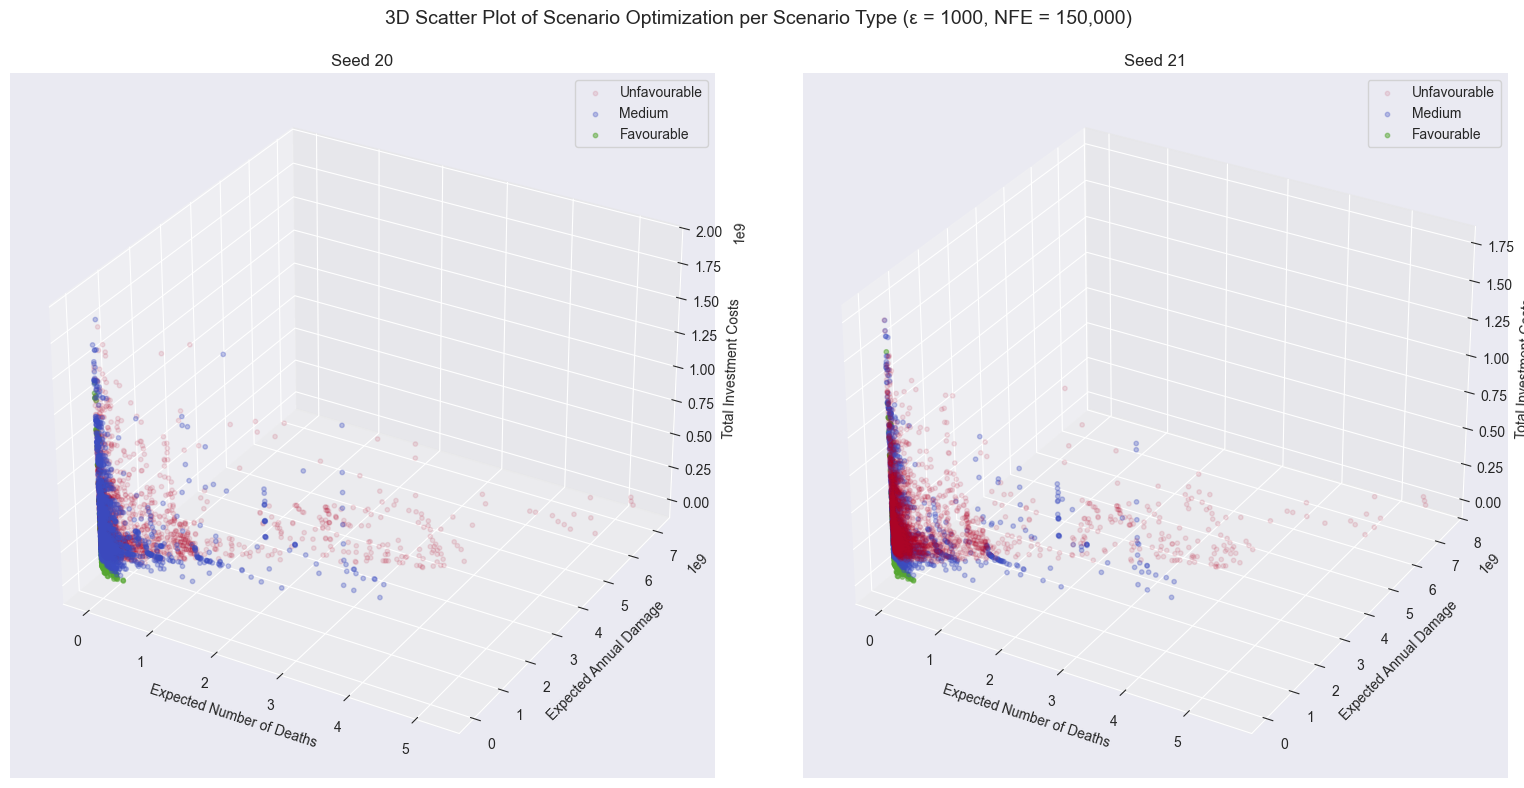

In [39]:
def plot_3d_scenario_optimization(fav_20, med_20, unfav_20, fav_21, med_21, unfav_21):
    """
    Creates a 3D scatter plot comparing scenario optimization results for two seeds (20 and 21).
    Shows 'Favourable', 'Medium', and 'Unfavourable' policy groups side-by-side.

    Parameters:
    - fav_20, med_20, unfav_20: DataFrames for seed 20
    - fav_21, med_21, unfav_21: DataFrames for seed 21
    """
    fig = plt.figure(figsize=(16, 8))
    colors = {'Unfavourable': '#b40426ff', 'Medium': '#3b4cc0ff', 'Favourable': '#55a630'}
    alphas = {'Unfavourable': 0.1, 'Medium': 0.3, 'Favourable': 0.5}
    sizes = 10

    def plot_seed(ax, fav, med, unfav, title):
        for df, label in zip([unfav, med, fav], ['Unfavourable', 'Medium', 'Favourable']):
            ax.scatter(
                df['Expected Number of Deaths'],
                df['Expected Annual Damage'],
                df['Total Investment Costs'],
                color=colors[label], label=label, alpha=alphas[label], s=sizes
            )
        ax.set_title(title)
        ax.set_xlabel('Expected Number of Deaths')
        ax.set_ylabel('Expected Annual Damage')
        ax.set_zlabel('Total Investment Costs')
        ax.legend()

    plot_seed(fig.add_subplot(1, 2, 1, projection='3d'), fav_20, med_20, unfav_20, 'Seed 20')
    plot_seed(fig.add_subplot(1, 2, 2, projection='3d'), fav_21, med_21, unfav_21, 'Seed 21')

    plt.suptitle('3D Scatter Plot of Scenario Optimization per Scenario Type (ε = 1000, NFE = 150,000)', fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    os.makedirs('plots', exist_ok=True)
    plt.savefig('plots/scenario_optimization_plot.png', facecolor='white', edgecolor='white', bbox_inches='tight', dpi=300)
    plt.show()

plot_3d_scenario_optimization(
    favourable_df_20, medium_df_20, unfavourable_df_20,
    favourable_df_21, medium_df_21, unfavourable_df_21
)

The plot above show the full 3d plot of the pareto fronts

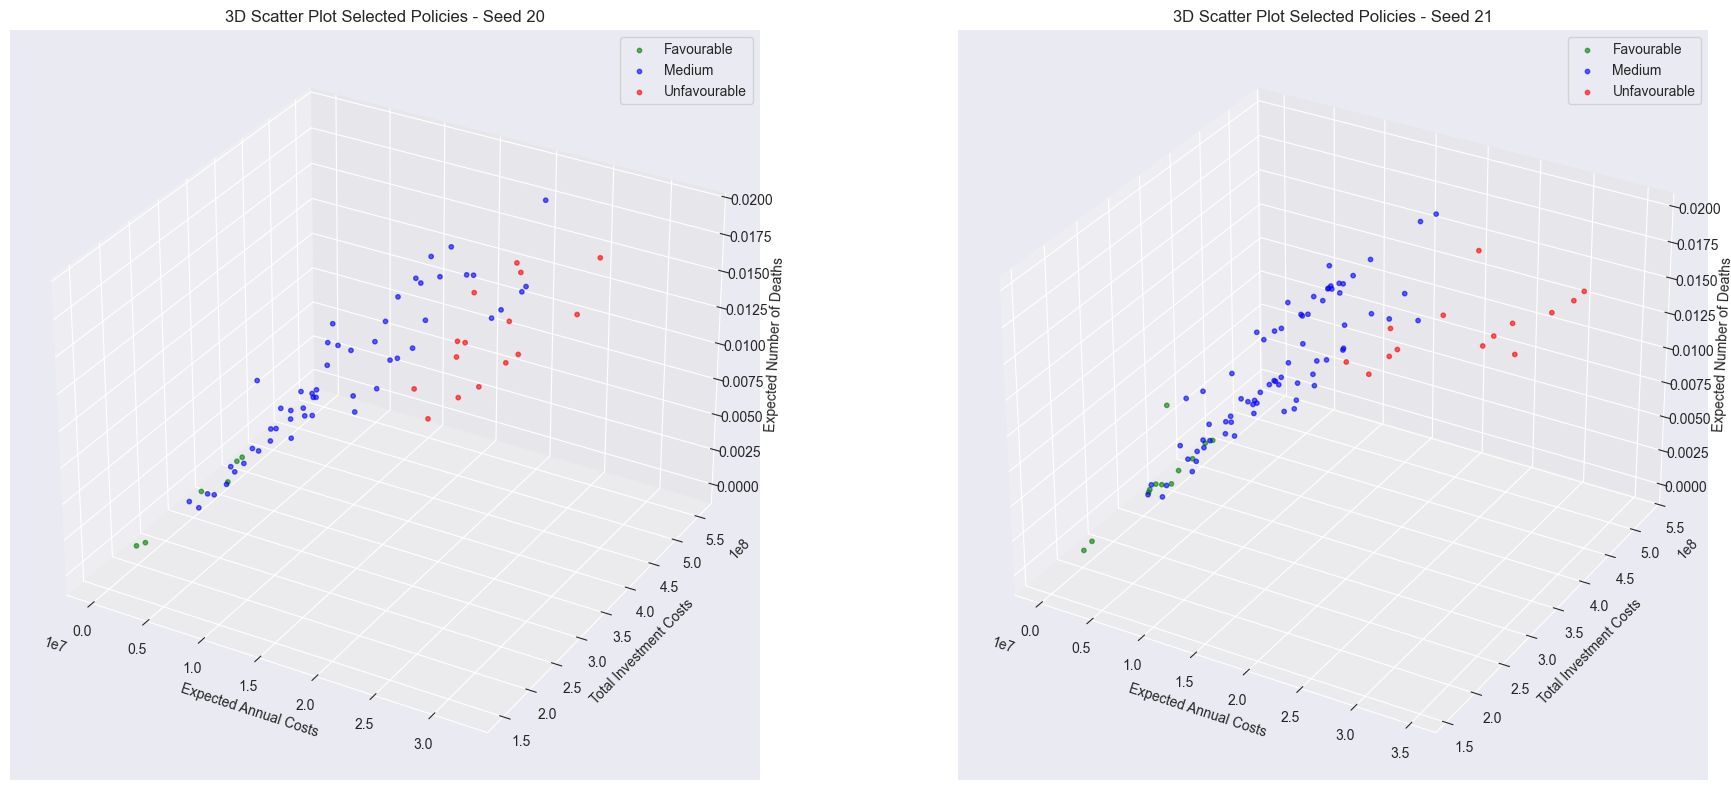

In [8]:
def plot_3d_policies_dual(fav_20, med_20, unfav_20, fav_21, med_21, unfav_21):
    """
    Plots two 3D scatter plots side by side for seed 20 and seed 21 scenarios.

    Parameters:
    - fav_20, med_20, unfav_20: DataFrames for seed 20
    - fav_21, med_21, unfav_21: DataFrames for seed 21
    """

    for df in [fav_20, med_20, unfav_20, fav_21, med_21, unfav_21]:
        df['Total Investment Costs'] = (
            df['Dike Investment Costs'] +
            df['RfR Investment Costs']
        )
        df['Expected Annual Costs'] = (
            df['Evacuation Costs'] +
            df['Expected Annual Damage']
        )

    fig = plt.figure(figsize=(20, 8))

    # Seed 20 plot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(fav_20['Expected Annual Costs'], fav_20['Total Investment Costs'], fav_20['Expected Number of Deaths'],
                color='green', label='Favourable', alpha=0.6, s=10)
    ax1.scatter(med_20['Expected Annual Costs'], med_20['Total Investment Costs'], med_20['Expected Number of Deaths'],
                color='blue', label='Medium', alpha=0.6, s=10)
    ax1.scatter(unfav_20['Expected Annual Costs'], unfav_20['Total Investment Costs'], unfav_20['Expected Number of Deaths'],
                color='red', label='Unfavourable', alpha=0.6, s=10)
    ax1.set_xlabel('Expected Annual Costs')
    ax1.set_ylabel('Total Investment Costs')
    ax1.set_zlabel('Expected Number of Deaths')
    ax1.set_title('3D Scatter Plot Selected Policies - Seed 20')
    ax1.legend()

    # Seed 21 plot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(fav_21['Expected Annual Costs'], fav_21['Total Investment Costs'], fav_21['Expected Number of Deaths'],
                color='green', label='Favourable', alpha=0.6, s=10)
    ax2.scatter(med_21['Expected Annual Costs'], med_21['Total Investment Costs'], med_21['Expected Number of Deaths'],
                color='blue', label='Medium', alpha=0.6, s=10)
    ax2.scatter(unfav_21['Expected Annual Costs'], unfav_21['Total Investment Costs'], unfav_21['Expected Number of Deaths'],
                color='red', label='Unfavourable', alpha=0.6, s=10)
    ax2.set_xlabel('Expected Annual Costs')
    ax2.set_ylabel('Total Investment Costs')
    ax2.set_zlabel('Expected Number of Deaths')
    ax2.set_title('3D Scatter Plot Selected Policies - Seed 21')
    ax2.legend()

    plt.tight_layout()
    plt.show()

fav_selected_20 = pd.read_csv("policies_seed_20/favourable_20_policy.csv")
med_selected_20 = pd.read_csv("policies_seed_20/medium_20_policy.csv")
unfav_selected_20 = pd.read_csv("policies_seed_20/unfavourable_20_policy.csv")

fav_selected_21 = pd.read_csv("policies_seed_21/favourable_21_policy.csv")
med_selected_21 = pd.read_csv("policies_seed_21/medium_21_policy.csv")
unfav_selected_21 = pd.read_csv("policies_seed_21/unfavourable_21_policy.csv")


plot_3d_policies_dual(
    fav_selected_20, med_selected_20, unfav_selected_20,
    fav_selected_21, med_selected_21, unfav_selected_21
)



The above plot shows the 3d plot for the selected polies in the first filtering for both seeds.

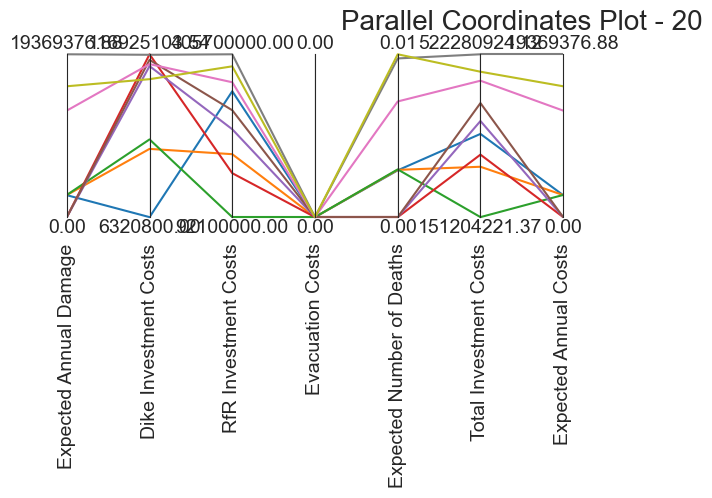

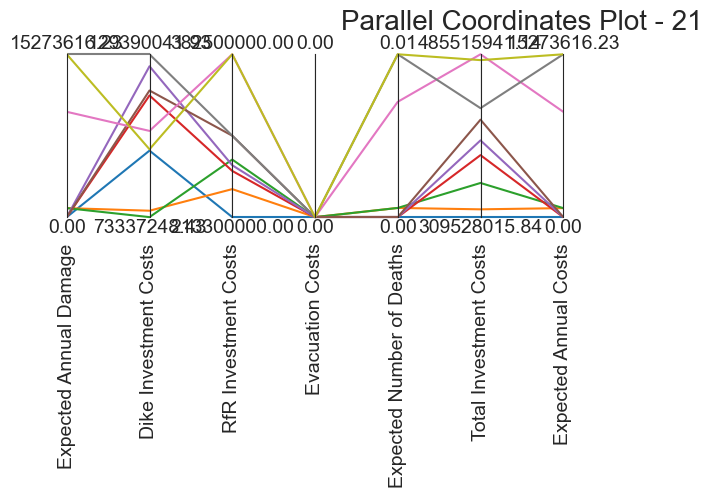

In [9]:
def plot_parallel_coords(metrics_df, seed_label):
    """
    Plots a parallel coordinates chart of numeric metrics from the last 8 columns of a DataFrame,
    labeled by the given seed.
    """
    # Select only the last 7 columns from the dataframe
    df_subset = metrics_df.iloc[:, -8:]

    # Keep only numeric columns to avoid issues with non-numeric data like 'scenario'
    df_numeric = df_subset.select_dtypes(include=['number'])

    # Generate axis limits and create the parallel coordinates plot
    limits = parcoords.get_limits(df_numeric)
    axes = parcoords.ParallelAxes(limits)
    axes.plot(df_numeric)

    plt.title(f"Parallel Coordinates Plot - {seed_label}", fontsize=20)
    plt.show()

top_3_combined_20 = pd.read_csv("policies_seed_20/top3_combined_20_policy.csv")
top_3_combined_21 = pd.read_csv("policies_seed_21/top3_combined_21_policy.csv")

plot_parallel_coords(top_3_combined_20, 20)
plot_parallel_coords(top_3_combined_21, 21)



For the 9 seeds that are then selected, these are the parallel plots for their own scenario.


## Robustness analysis
The 9 policies are first run on the 10 scenarios. These policies are then filtered, which can be seen in Main_data_generation_document.ipynb. From this selection, a final set of 2 policies per seed is left.

These 4 policies, 2 from seed 20 and 2 from seed 21 are then run against 100.000 new scenarios, the results are plotted here

### Aggregation 2 robustness
First everything was run with aggregation 2. The data is loaded first and an overview of the metrics is shown by the following code.


In [10]:
def print_robustness_summary(sorted_df, performance_columns):
    for i, row in sorted_df.iterrows():
        print(f"\nRank {i+1} Policy: {row['Policy']}")
        print(f"{'Metric':30} {'Mean':>15} {'Std':>15} {'Max Regret':>15} {'Mean Regret':>15}")
        print("-" * 90)
        for col in performance_columns:
            print(f"{col:30} "
                  f"{row[f'{col} Mean']:15.6g} "
                  f"{row[f'{col} Std']:15.6g} "
                  f"{row[f'{col} Max Regret']:15.6g} "
                  f"{row[f'{col} Mean Regret']:15.6g}")

def load_and_print_summary(folder_path, file):
    performance_cols = [
        'Expected Number of Deaths',
        'Expected Annual Damage',
        'Evacuation Costs',
        'Total Investment Costs'
    ]

    robustness_path = os.path.join(folder_path, file)
    robustness_df = pd.read_csv(robustness_path)
    print_robustness_summary(robustness_df, performance_cols)

load_and_print_summary('robustness_results', 'robustness_summary.csv' )




Rank 1 Policy: 6_s20
Metric                                    Mean             Std      Max Regret     Mean Regret
------------------------------------------------------------------------------------------
Expected Number of Deaths             0.197197         0.36287        0.427763     0.000965981
Expected Annual Damage             2.73114e+08      5.4568e+08     5.90497e+08          965384
Evacuation Costs                             0               0               0               0
Total Investment Costs              4.6206e+08               0      1.1393e+08      1.1393e+08

Rank 2 Policy: 8_s20
Metric                                    Mean             Std      Max Regret     Mean Regret
------------------------------------------------------------------------------------------
Expected Number of Deaths             0.197813        0.362872        0.427763      0.00158221
Expected Annual Damage             2.73813e+08     5.45682e+08     5.90497e+08     1.66474e+06
Evacuation Cos

The different outcomes in numbers for each policy

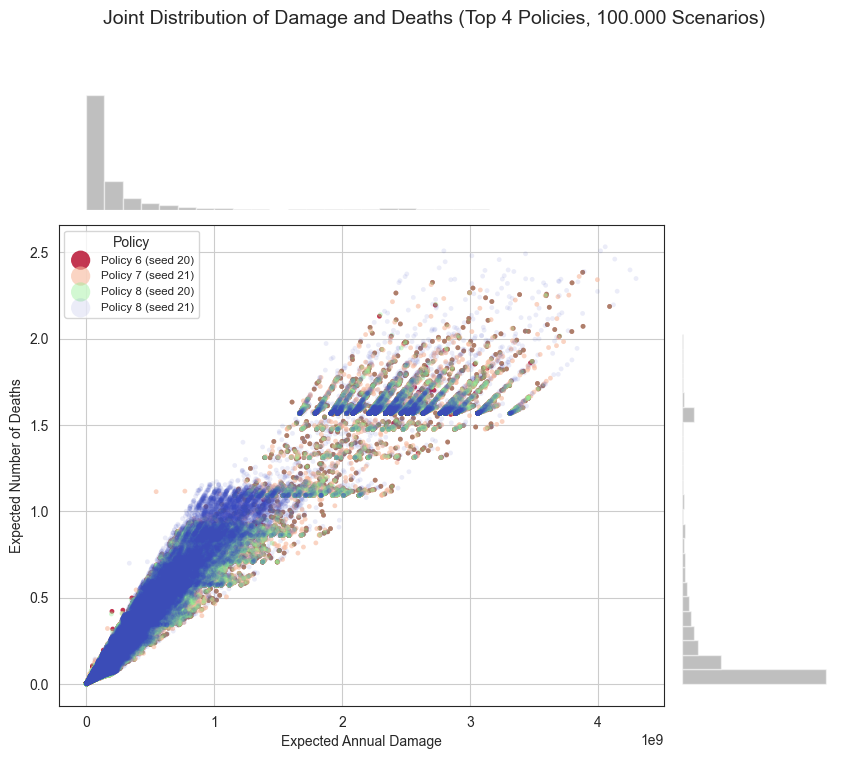

In [11]:
folder_path = 'robustness_results'
policy_colors = ['#b40426ff', '#f7b89cff', '#90ee90ff', '#3b4cc0ff']
color_map = {}

# Alpha levels from bottom to top
alpha_levels = [0.8, 0.6, 0.4, 0.1]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05)
ax_scatter = fig.add_subplot(gs[1, 0])
ax_hist_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_hist_y = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

all_damages = []
all_deaths = []
used_labels = set()

for i, filename in enumerate(sorted(os.listdir(folder_path))):
    if '_robustness_' in filename and filename.endswith('.csv'):
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath)

        if all(col in df.columns for col in ['Expected Annual Damage', 'Expected Number of Deaths']):
            match = re.search(r'policy_(\d+)_s(\d+)', filename)
            if match:
                policy_id = match.group(1)
                seed_id = match.group(2)
                label = f"Policy {policy_id} (seed {seed_id})"

                if label not in color_map:
                    color_map[label] = policy_colors[len(color_map) % len(policy_colors)]
                color = color_map[label]

                alpha = alpha_levels[len(color_map)-1]  # assign alpha by order

                ax_scatter.scatter(
                    df['Expected Annual Damage'],
                    df['Expected Number of Deaths'],
                    color=color,
                    label=label if label not in used_labels else None,
                    alpha=alpha,
                    s=12,
                    edgecolors='none'
                )
                used_labels.add(label)

                all_damages.extend(df['Expected Annual Damage'])
                all_deaths.extend(df['Expected Number of Deaths'])

# Histograms
ax_hist_x.hist(all_damages, bins=30, color='gray', alpha=0.5)
ax_hist_y.hist(all_deaths, bins=30, orientation='horizontal', color='gray', alpha=0.5)
ax_hist_x.axis('off')
ax_hist_y.axis('off')

# Labels and legend
ax_scatter.set_xlabel('Expected Annual Damage')
ax_scatter.set_ylabel('Expected Number of Deaths')
ax_scatter.grid(True)
plt.suptitle('Joint Distribution of Damage and Deaths (Top 4 Policies, 100.000 Scenarios)', fontsize=14)

ax_scatter.legend(title='Policy', markerscale=4, fontsize='small')

output_folder = 'plots'
os.makedirs(output_folder, exist_ok=True)
save_path = os.path.join(output_folder, 'top_policies_plot.png')
plt.savefig(save_path, facecolor='white', edgecolor='white', bbox_inches='tight', dpi=300)

plt.show()


A visualization of the expected annual damages and the expected number of deaths for each policy against the 100.000 scenarios.
Note the small peak in the density at expected deaths 1.6

### Aggregation 3 robustness
Because of the polital arena, we wanted to look at a different aggregation, one that is also focussed on the different dike rings.

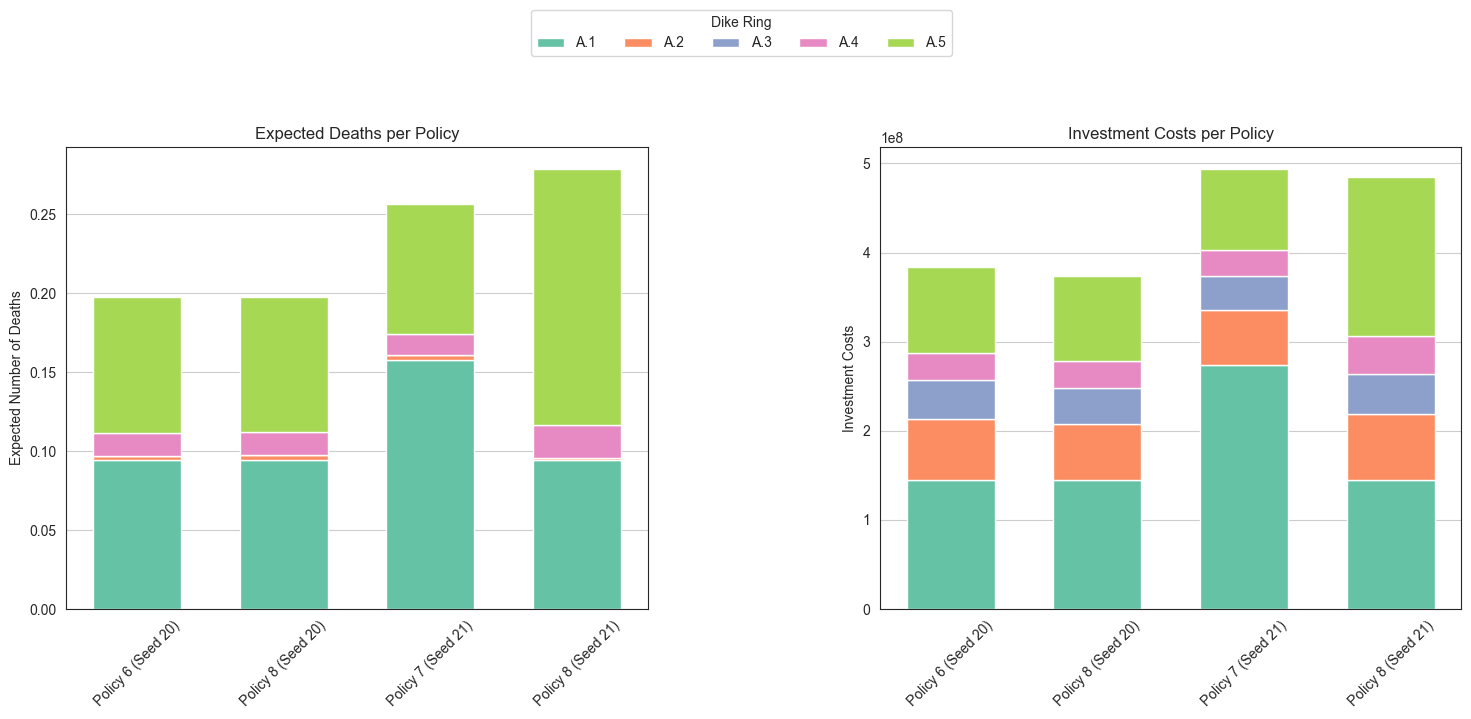

In [12]:
folder_path = 'robustness_results_other_aggregation'
dike_ids = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
alpha_levels = [0.5, 0.3, 0.2, 0.05]
colors = sns.color_palette("Set2", len(dike_ids))

desired_order = [
    "Policy 6 (Seed 20)",
    "Policy 8 (Seed 20)",
    "Policy 7 (Seed 21)",
    "Policy 8 (Seed 21)"
]

csv_path = os.path.join('robustness_results_other_aggregation', 'combined_outcomes_summary.csv')
final_summary_df = pd.read_csv(csv_path)

# Ensure Policy column is treated as categorical for consistent ordering
final_summary_df['Policy'] = pd.Categorical(final_summary_df['Policy'], categories=desired_order, ordered=True)

# Pivot data: rows are policies, columns are dike rings
deaths_pivot = final_summary_df.pivot(index='Policy', columns='Dike Ring', values='Exp. Deaths (Mean)')
costs_pivot = final_summary_df.pivot(index='Policy', columns='Dike Ring', values='Investment Cost (Mean)')

# Set color palette for consistent dike coloring
dike_colors = dict(zip(dike_ids, colors))

# Create side-by-side subplots with extra spacing between them
fig, axs = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'wspace': 0.4})  # increased wspace

# Bar width (smaller)
bar_width = 0.6
x = np.arange(len(deaths_pivot))

# Plot 1: Stacked Barplot for Expected Deaths
bottom = np.zeros(len(deaths_pivot))
for dike in dike_ids:
    axs[0].bar(x, deaths_pivot[dike], bottom=bottom,
               label=dike, color=dike_colors[dike], width=bar_width)
    bottom += deaths_pivot[dike].fillna(0)

axs[0].set_ylabel("Expected Number of Deaths")
axs[0].set_title("Expected Deaths per Policy")
axs[0].set_xticks(x)
axs[0].set_xticklabels(deaths_pivot.index, rotation=45)
axs[0].grid(True, axis='y')

# Plot 2: Stacked Barplot for Investment Costs
bottom = np.zeros(len(costs_pivot))
for dike in dike_ids:
    axs[1].bar(x, costs_pivot[dike], bottom=bottom,
               label=dike, color=dike_colors[dike], width=bar_width)
    bottom += costs_pivot[dike].fillna(0)

axs[1].set_ylabel("Investment Costs")
axs[1].set_title("Investment Costs per Policy")
axs[1].set_xticks(x)
axs[1].set_xticklabels(costs_pivot.index, rotation=45)
axs[1].grid(True, axis='y')

# Common legend above
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, title='Dike Ring', loc='upper center', ncol=len(dike_ids), bbox_to_anchor=(0.5, 1.12))

plt.tight_layout(rect=[0, 0, 1, 1.05])  # Leave space for the legend
plt.show()


The stacked barplots show the different distributions of the burdens of hte deaths and the costs for each policy.